In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from morpheus.classifier import Classifier
from morpheus.data import example
%matplotlib inline
import pickle

2022-12-02 03:40:46.620037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-02 03:40:46.620089: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-02 03:40:46.674777: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 03:40:47.819683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-02 03:40:47.819808: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

# Getting Data H,J,V,z

F160W (H) / F125W (J) / F606W (V) / F850LP (z)

In [2]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
f105w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))
f125w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f125w_v1_drz.fits'))
f140w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f140w_v1_drz.fits'))
f160w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits'))


f356w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_acs-60mas_smacs0723-73_f435w_v1_drc.fits'))
f410m_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_acs-60mas_smacs0723-73_f606w_v1_drc.fits'))
f444w_nircam_i2d = (get_pkg_data_filename('/data/jip/1st_TASK_Relics_SMACS/reducfed-img/60mas/hlsp_relics_hst_acs-60mas_smacs0723-73_f814w_v1_drc.fits'))

h, j, v, z = f105w_nircam_i2d, f125w_nircam_i2d, f140w_nircam_i2d, f160w_nircam_i2d

# fits 특성에 따라서 ext 바꿔줘야 
hdat = fits.getdata(h, ext=0)
jdat = fits.getdata(j, ext=0)
vdat = fits.getdata(v, ext=0)
zdat = fits.getdata(z, ext=0)

h_header = fits.getheader(h, ext=0)
j_header = fits.getheader(j, ext=0)
v_header = fits.getheader(v, ext=0)
z_header = fits.getheader(z, ext=0)

# Raw Image Show

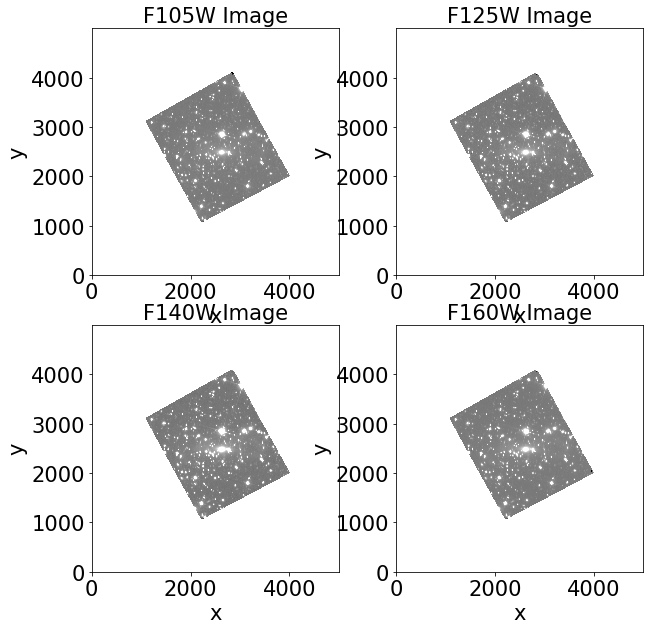

In [3]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hdat, jdat, vdat, zdat], ['F105W', 'F125W', 'F140W', 'F160W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0.1, vmax=0.1)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

In [22]:
hdat.shape

(5000, 5000)

# Image Cut and Show 

## 1) Given X Y ==> Cut the image


In [4]:
from astropy.nddata import Cutout2D
from astropy import units as u
cutoutposition = (2500, 2500)
cutoutsize = (3400, 3400)
hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F115W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=0, vmax=0.3853037)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()


## 2) Given RA/DEC ==> Cut the image

Set DATE-AVG to '2022-06-21T23:30:42.583' from MJD-AVG.
Set DATE-END to '2022-06-22T00:03:43.515' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.785729 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725461621.089 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T00:41:54.035' from MJD-AVG.
Set DATE-END to '2022-06-22T01:14:35.286' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.795264 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725510974.395 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T01:53:47.550' from MJD-AVG.
Set DATE-END to '2022-06-22T02:27:14.386' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.800090 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725535860.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-22T02:59:46.731' from MJD-AVG.
Set DATE-END to '2022-06-22T03:26:17.615' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.812393 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725599046.468 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


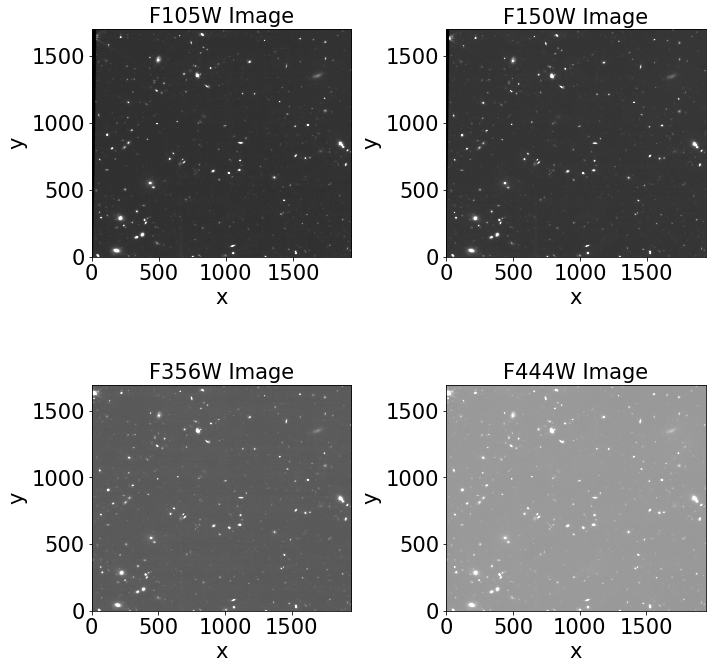

In [ ]:
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

wcs_h = WCS(h_header)
wcs_j = WCS(j_header)
wcs_v = WCS(v_header)
wcs_z = WCS(z_header)

cutoutposition_radec = [[14, 19, 28], [52, 53, 42]] #RA(hour, min, sec), DEC(deg, min, sec)형식
squarecutpoint_radec =  [[14, 19, 19.023], [52, 53, 41.14]] #RA(hour, min, sec), DEC(deg, min, sec)형식

def skycoord(x):
    ra = (x[0][0]+x[0][1]/60+x[0][2]/3600)*15*u.deg
    dec = (x[1][0]+x[1][1]/60+x[1][2]/3600)*u.deg
    c = SkyCoord(ra, dec)
    #print(c)
    return c

def cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs):
    cutoutposition = np.array(skycoord_to_pixel(skycoord(cutoutposition_radec), wcs))
    squarecutpoint = np.array(skycoord_to_pixel(skycoord(squarecutpoint_radec), wcs))
    #print(cutoutposition)
    #print(squarecutpoint)
    cutoutsize = abs(squarecutpoint-cutoutposition) * 2
    #print(cutoutsize)
    return np.array([cutoutposition, cutoutsize])
    
hcut = Cutout2D(hdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_h)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_h)[1]).data
jcut = Cutout2D(jdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_j)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_j)[1]).data
vcut = Cutout2D(vdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_v)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_v)[1]).data
zcut = Cutout2D(zdat, cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_z)[0], cutoutreturn(cutoutposition_radec, squarecutpoint_radec, wcs=wcs_z)[1]).data
#jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
#vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
#zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data

f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hcut,jcut,vcut,zcut], ['F105W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray',  vmin=-0, vmax=0.38530371)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

### image resizing for Morpheus (same size로) --> 추후 반드시 해결할 것 PIL VS cv2 

In [68]:
from PIL import Image
import cv2 

hcut_resize = cv2.resize(hcut, dsize=np.shape(hcut), interpolation=cv2.INTER_NEAREST)
jcut_resize = cv2.resize(jcut, dsize=(np.shape(hcut)))
vcut_resize = cv2.resize(vcut, dsize=(np.shape(hcut)))
zcut_resize = cv2.resize(zcut, dsize=(np.shape(hcut)))



/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:479: RuntimeWarning: overflow encountered in subtract
  A_scaled -= a_min
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:480: RuntimeWarning: overflow encountered in subtract
  vrange -= a_min
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:503: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py:1254: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)
/home/jip/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:505: RuntimeWarning: overflow encountered in add
  A_resampled += a_min


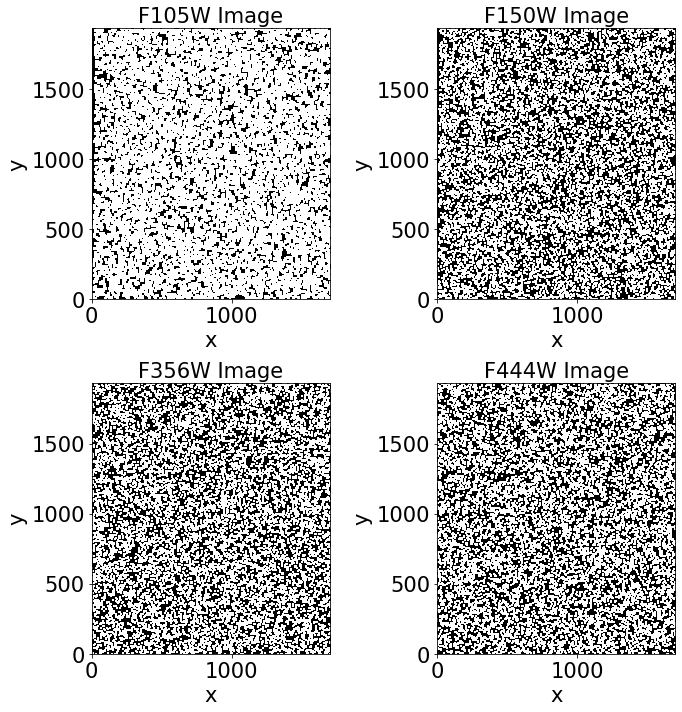

In [67]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()
for ax, arr, band in zip(axes, [hcut_resize,jcut_resize,vcut_resize,zcut_resize], ['F105W', 'F150W', 'F356W', 'F444W']):
    ax.set_title(f'{band} Image', fontsize=21)
    ax.imshow(arr, origin='lower', cmap='gray')#,  vmin=0, vmax=0.38530371)
    ax.set_xlabel('x', fontsize=21)
    ax.set_ylabel('y', fontsize=21)
    ax.tick_params(axis='x', labelsize=21)
    ax.tick_params(axis='y', labelsize=21)

plt.tight_layout()
plt.show()

# Running Morpheus

In [5]:
classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)

# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1
segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)

catalog = Classifier.catalog_from_classified(classified, hcut, segmap)

rgb = Classifier.colorize_classified(classified)


classifying:   0%|          | 0/11296 [00:00<?, ?batch/s]/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:143: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return LAYERS.batch_normalization(inputs, training=is_training, axis=axis)
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:162: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  inputs = LAYERS.conv2d(
/home/jip/anaconda3/lib/python3.9/site-packages/morpheus/core/unet.py:149: UserWarning: `tf.layers.dropout` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dropout` instead.
  return LAYERS.dropout(inputs, rate=rate

Building Markers...
Watershedding...


100%|██████████| 3400/3400 [00:19<00:00, 171.03it/s]


# Saving Morpheus Classified Result to Pickle

Once calculation is done to here, don't need to calculate again.

In [6]:
# save with it 
with open("classified_result.pickle","wb") as f:
    pickle.dump(classified, f)

In [10]:
# load with it
with open("classified_result.pickle","rb") as fi:
    classified = pickle.load(fi)


mask = np.zeros_like(hcut, np.int)
mask[5:-5, 5:-5] = 1
segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)
rgb = Classifier.colorize_classified(classified)
catalog = Classifier.catalog_from_classified(classified, hcut, segmap)


/tmp/ipykernel_48939/3695551349.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 3400/3400 [00:20<00:00, 166.79it/s]


# Colorizing Result

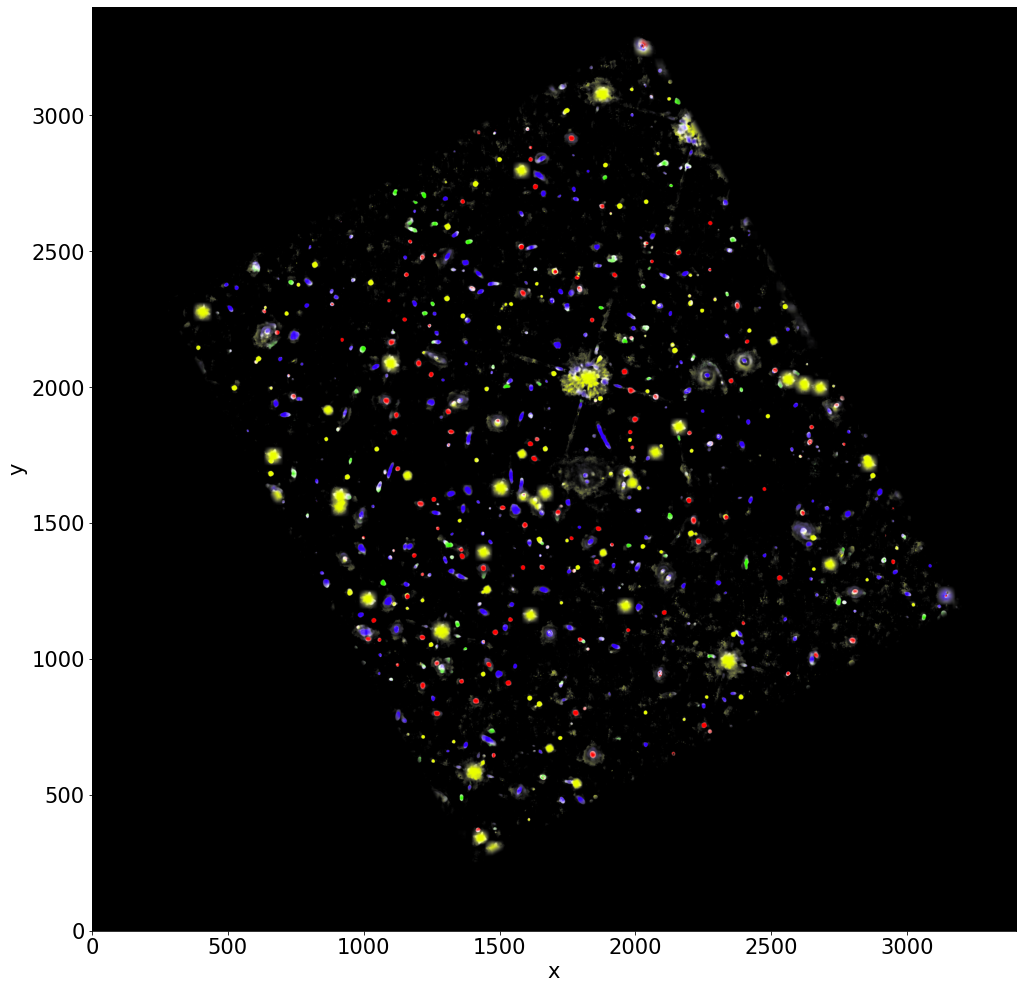

In [11]:

plt.figure(figsize=(17, 17))
plt.xlabel('x', fontsize=21)
plt.ylabel('y', fontsize=21)
plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.imshow(rgb, origin='lower')
plt.show()

# Saving Result to Dataframe, CSV

In [12]:
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs import WCS

wcs = WCS(h_header)

morpheus_result = pd.DataFrame(catalog)
morpheus_result['ra'] = pd.Series(dtype='float')
morpheus_result['dec'] = pd.Series(dtype='float')
morpheus_result['x'] = pd.Series(dtype='float')
morpheus_result['y'] = pd.Series(dtype='float')
morpheus_result['p_sph'] = pd.Series(dtype='float')
morpheus_result['p_disk'] = pd.Series(dtype='float')
morpheus_result['p_irr'] = pd.Series(dtype='float')
morpheus_result['p_ps'] = pd.Series(dtype='float')

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['x'][i] = morpheus_result['location'][i][1]
    morpheus_result['y'][i] = morpheus_result['location'][i][0]
    morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
    morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
    morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
    morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
   
morpheus_result['real_x'] = morpheus_result['x']+(cutoutposition[0]-cutoutsize[0]/2)
morpheus_result['real_y'] = morpheus_result['y']+(cutoutposition[1]-cutoutsize[1]/2)

for i in range(np.size(morpheus_result['ra'])):
    morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
    morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree


/tmp/ipykernel_48939/2421671279.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_48939/2421671279.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_48939/2421671279.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0

In [13]:
import os 
# os.makedirs("./output")
morpheus_result.to_csv("./morpheus_result.csv")

# Filtering High-Probabilithy Disk Candidates

In [25]:
datmor = pd.DataFrame(pd.read_csv("morpheus_result.csv"))
datmor_highdisk=datmor.loc[datmor['p_disk'] > 0.5]
datmor_highdisk

Unnamed: 0   id      location  \
3             3    4   [478, 1798]   
4             4    5   [480, 1727]   
6             6    7   [515, 1570]   
14           14   15   [682, 1373]   
15           15   16   [685, 2035]   
..          ...  ...           ...   
468         468  470  [2810, 2189]   
471         471  473  [2837, 1651]   
480         480  482  [2999, 1985]   
486         486  488  [3109, 2031]   
489         489  491  [1984, 1810]   

                                            morphology          ra        dec  \
3    [0.00010179398054179144, 0.9881299428262994, 0...  110.827689 -73.474553   
4    [5.115303287620794e-06, 0.7866715906354904, 0....  110.831850 -73.474519   
6    [0.040719100571250104, 0.9334980327541014, 0.0...  110.841049 -73.473936   
14   [0.000454015537446154, 0.9819769608085765, 0.0...  110.852588 -73.471152   
15   [-0.00040097800237894635, 0.9831248185986101, ...  110.813807 -73.471102   
..                                                 ...         ...        ...   
468  [1.7035166650158888e-05, 0.5792714568722044, 0...  110.804845 -73.435684   
471  [0.0004824623071423295, 0.9096064665716198, 0....  110.836296 -73.435236   
480  [0.1053975136416836, 0.8577302155271458, 0.034...  110.816774 -73.432535   
486  [0.2305902258584911, 0.6850258404230789, 0.056...  110.814087 -73.430702   
489  [0.010117260576985324, 0.7647894345367314, 0.0...  110.826996 -73.449453   

          x       y     p_sph    p_disk     p_irr      p_ps  real_x  real_y  
3    1798.0   478.0  0.000102  0.988130  0.011768  0.000000  2598.0  1278.0  
4    1727.0   480.0  0.000005  0.786672  0.205418  0.007905  2527.0  1280.0  
6    1570.0   515.0  0.040719  0.933498  0.015102  0.010681  2370.0  1315.0  
14   1373.0   682.0  0.000454  0.981977  0.017222  0.000347  2173.0  1482.0  
15   2035.0   685.0 -0.000401  0.983125  0.017060  0.000216  2835.0  1485.0  
..      ...     ...       ...       ...       ...       ...     ...     ...  
468  2189.0  2810.0  0.000017  0.579271  0.418027  0.002684  2989.0  3610.0  
471  1651.0  2837.0  0.000482  0.909606  0.089894  0.000017  2451.0  3637.0  
480  1985.0  2999.0  0.105398  0.857730  0.034272  0.002600  2785.0  3799.0  
486  2031.0  3109.0  0.230590  0.685026  0.056798  0.027586  2831.0  3909.0  
489  1810.0  1984.0  0.010117  0.764789  0.018178  0.206915  2610.0  2784.0  

[179 rows x 14 columns]

In [26]:
np.mean(datmor_highdisk['p_disk'])

0.8869296565110341

# Plotting detected sources on image and colormap

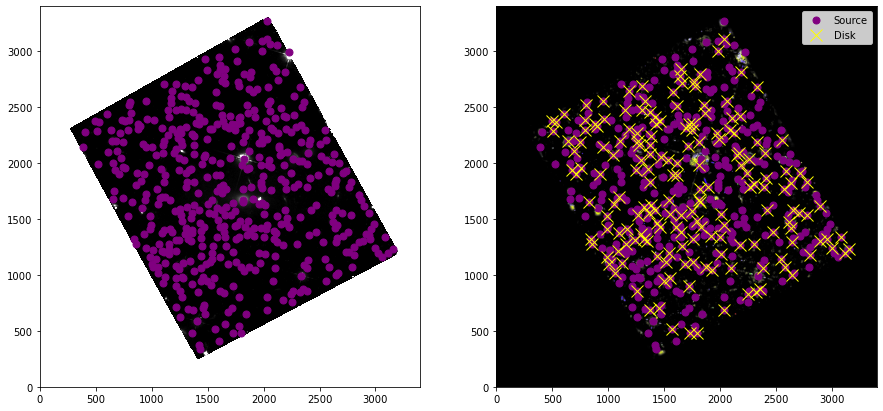

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.38)
axs[0].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple')
axs[1].imshow(rgb, origin='lower')
axs[1].plot(datmor['x'], datmor['y'], 'o', ms=7, color='purple', label='Source')
axs[1].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'x', ms=12, color='yellow', label='Disk')
axs[1].legend()


Red = Spheroid <br>
Blue = Disk <br>
Green = Irregular <br>
Yellow = Point Source (compact) <br>
Back = Background <br>
White = Can't Classify (two class prob is so similar) <br>

# Relics Catalog 주변 Source Cutout

In [8]:
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

In [9]:
def source_morpheus_run(x, y):
    cutoutposition = (x, y)
    cutoutsize = (60, 60)
    hcut = Cutout2D(hdat, cutoutposition, cutoutsize).data
    jcut = Cutout2D(jdat, cutoutposition, cutoutsize).data
    vcut = Cutout2D(vdat, cutoutposition, cutoutsize).data
    zcut = Cutout2D(zdat, cutoutposition, cutoutsize).data
    classified = Classifier.classify(h=hcut, j=jcut, v=vcut, z=zcut)
    # the mask tells the segmentation mapping algorithm to ignore
    # the areas unclassified as a result of the windowing classification
    # method used.
    mask = np.zeros_like(hcut, np.int)
    mask[5:-5, 5:-5] = 1
    segmap = Classifier.segmap_from_classified(classified, hcut, mask=mask)
    catalog = Classifier.catalog_from_classified(classified, hcut, segmap)
    rgb = Classifier.colorize_classified(classified)

    wcs = WCS(h_header)

    morpheus_result = pd.DataFrame(catalog)
    morpheus_result['ra'] = pd.Series(dtype='float')
    morpheus_result['dec'] = pd.Series(dtype='float')
    morpheus_result['x'] = pd.Series(dtype='float')
    morpheus_result['y'] = pd.Series(dtype='float')
    morpheus_result['p_sph'] = pd.Series(dtype='float')
    morpheus_result['p_disk'] = pd.Series(dtype='float')
    morpheus_result['p_irr'] = pd.Series(dtype='float')
    morpheus_result['p_ps'] = pd.Series(dtype='float')

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['x'][i] = morpheus_result['location'][i][1]
        morpheus_result['y'][i] = morpheus_result['location'][i][0]
        morpheus_result['p_sph'][i] = morpheus_result['morphology'][i][0]
        morpheus_result['p_disk'][i] = morpheus_result['morphology'][i][1]
        morpheus_result['p_irr'][i] = morpheus_result['morphology'][i][2]
        morpheus_result['p_ps'][i] = morpheus_result['morphology'][i][3]
    
    morpheus_result['real_x'] = morpheus_result['x']+(cutoutposition[0]-cutoutsize[0]/2)
    morpheus_result['real_y'] = morpheus_result['y']+(cutoutposition[1]-cutoutsize[1]/2)

    for i in range(np.size(morpheus_result['ra'])):
        morpheus_result['ra'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).ra.degree
        morpheus_result['dec'][i] = pixel_to_skycoord(morpheus_result['real_x'][i], morpheus_result['real_y'][i], wcs).dec.degree
    
    return morpheus_result


In [10]:
colnames_cat = ['id', 'RA','Dec', 'x', 'y', 'fwhm', 
'area', 'stel', 'ell', 'theta', 'nf5sig', 'nfobs', 'f435w_mag', 'f435w_magerr',
'f435w_flux', 'f435w_fluxerr', 'f435w_fluxnJy', 'f435w_fluxnJyerr', 'f435w_sig', 'f606w_mag', 'f606w_magerr', 'f606w_flux', 
'f606w_fluxerr' , 'f606w_fluxnJy', 'f606w_fluxnJyerr', 'f606w_sig', 'f814w_mag', 'f814w_magerr', 'f814w_flux', 'f814w_fluxerr', 
'f814w_fluxnJy', 'f814w_fluxnJyerr' , 'f814w_sig' , 'f105w_mag', 'f105w_magerr', 'f105w_flux', 'f105w_fluxerr', 'f105w_fluxnJy', 
'f105w_fluxnJyerr', 'f105w_sig', 'f125w_mag', 'f125w_magerr', 'f125w_flux', 'f125w_fluxerr', 'f125w_fluxnJy', 'f125w_fluxnJyerr', 'f125w_sig', 
'f140w_mag', 'f140w_magerr', 'f140w_flux', 'f140w_fluxerr', 'f140w_fluxnJy', 'f140w_fluxnJyerr', 'f140w_sig', 'f160w_mag', 'f160w_magerr', 'f160w_flux',
'f160w_fluxerr', 'f160w_fluxnJy', 'f160w_fluxnJyerr', 'f160w_sig', 'bright_mag', 'bright_magerr', 'zb', 'zbmin', 'zbmax', 'tb', 'odds', 'chisq', 
'chisq2', 'M0', 'zml', 'tml'] 

dat_cat = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)

df = pd.DataFrame(columns =['id','location','morphology','ra','dec','x','y','p_sph','p_disk','p_irr','p_ps','real_x','real_y'])

for i in range(np.size(dat_cat['x'])):
    print(f"rate is ======== {100*i/np.size(dat_cat['x'])}")
    add = source_morpheus_run(dat_cat['x'][i], dat_cat['y'][i])
    df = pd.concat([df, add])

rate is ======== 0.0


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9754.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.06779661016949153


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9296.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.13559322033898305


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9591.00it/s]


rate is ======== 0.2033898305084746


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9960.75it/s]


rate is ======== 0.2711864406779661


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9816.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.3389830508474576


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5000.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.4067796610169492


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9941.46it/s]


rate is ======== 0.4745762711864407


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10021.83it/s]


rate is ======== 0.5423728813559322


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9957.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.6101694915254238


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9751.55it/s]


rate is ======== 0.6779661016949152


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9996.75it/s]


rate is ======== 0.7457627118644068


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9717.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.8135593220338984


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9975.35it/s]


rate is ======== 0.8813559322033898


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 0.9491525423728814


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9713.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.0169491525423728


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9706.79it/s]


rate is ======== 1.0847457627118644


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9753.06it/s]


rate is ======== 1.152542372881356


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9352.54it/s]


rate is ======== 1.2203389830508475


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9391.28it/s]


rate is ======== 1.2881355932203389


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9365.42it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.3559322033898304


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9715.78it/s]


rate is ======== 1.423728813559322


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4613.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.4915254237288136


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9939.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.5593220338983051


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9874.37it/s]


rate is ======== 1.6271186440677967


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9767.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.694915254237288


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9745.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.7627118644067796


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9966.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.8305084745762712


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9845.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.8983050847457628


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8504.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 1.9661016949152543


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9604.54it/s]


rate is ======== 2.0338983050847457


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9605.28it/s]


rate is ======== 2.1016949152542375


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9896.89it/s]


rate is ======== 2.169491525423729


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9611.15it/s]


rate is ======== 2.23728813559322


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7467.83it/s]


rate is ======== 2.305084745762712


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9395.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 2.3728813559322033


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7586.24it/s]


rate is ======== 2.440677966101695


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9399.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 2.5084745762711864


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9855.42it/s]


rate is ======== 2.5762711864406778


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9437.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 2.6440677966101696


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9111.45it/s]


rate is ======== 2.711864406779661


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9925.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 2.7796610169491527


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8682.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 2.847457627118644


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9476.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 2.9152542372881354


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9062.56it/s]


rate is ======== 2.983050847457627


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9784.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.0508474576271185


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9275.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.1186440677966103


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9879.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.1864406779661016


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9514.49it/s]


rate is ======== 3.2542372881355934


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9777.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.3220338983050848


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8781.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.389830508474576


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9807.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.457627118644068


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9468.31it/s]


rate is ======== 3.5254237288135593


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9159.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.593220338983051


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6606.59it/s]


rate is ======== 3.6610169491525424


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8232.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 3.7288135593220337


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9896.89it/s]


rate is ======== 3.7966101694915255


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9921.48it/s]


rate is ======== 3.864406779661017


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9718.41it/s]


rate is ======== 3.9322033898305087


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10152.83it/s]


rate is ======== 4.0


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9852.34it/s]


rate is ======== 4.067796610169491


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9899.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.135593220338983


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8580.82it/s]


rate is ======== 4.203389830508475


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9916.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.271186440677966


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9187.63it/s]


rate is ======== 4.338983050847458


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9925.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.406779661016949


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9896.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.47457627118644


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9746.64it/s]


rate is ======== 4.5423728813559325


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10027.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 4.610169491525424


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9882.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.677966101694915


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9911.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.745762711864407


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9839.24it/s]


rate is ======== 4.813559322033898


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9730.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.88135593220339


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 4.9491525423728815


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9872.05it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.016949152542373


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.084745762711864


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9723.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.1525423728813555


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9786.06it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.220338983050848


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9765.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.288135593220339


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9767.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.3559322033898304


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9760.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.423728813559322


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9650.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.491525423728813


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9735.71it/s]


rate is ======== 5.559322033898305


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9830.02it/s]


rate is ======== 5.627118644067797


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8745.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.694915254237288


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9919.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.762711864406779


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9866.63it/s]


rate is ======== 5.830508474576271


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9823.49it/s]


rate is ======== 5.898305084745763


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9846.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 5.966101694915254


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9777.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.033898305084746


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9495.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.101694915254237


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9874.76it/s]


rate is ======== 6.169491525423729


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9747.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.237288135593221


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9893.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.305084745762712


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.372881355932203


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9661.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.440677966101695


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9996.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.508474576271187


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9774.65it/s]


rate is ======== 6.576271186440678


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9800.92it/s]


rate is ======== 6.6440677966101696


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9365.77it/s]


rate is ======== 6.711864406779661


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9656.14it/s]


rate is ======== 6.779661016949152


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9879.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.8474576271186445


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9720.29it/s]


rate is ======== 6.915254237288136


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9898.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 6.983050847457627


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9471.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.0508474576271185


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9857.35it/s]


rate is ======== 7.11864406779661


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9905.85it/s]


rate is ======== 7.186440677966102


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.254237288135593


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9490.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.322033898305085


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9689.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.389830508474576


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9885.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.4576271186440675


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9633.22it/s]


rate is ======== 7.52542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9934.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.593220338983051


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9894.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.661016949152542


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9868.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.728813559322034


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9700.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.796610169491525


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9487.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.864406779661017


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9959.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 7.932203389830509


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7669.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.0


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9858.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.067796610169491


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9761.01it/s]


rate is ======== 8.135593220338983


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4847.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.203389830508474


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9646.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.271186440677965


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4950.10it/s]


rate is ======== 8.338983050847459


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9195.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.40677966101695


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9749.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.474576271186441


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9537.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.542372881355933


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9612.25it/s]


rate is ======== 8.610169491525424


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9677.30it/s]


rate is ======== 8.677966101694915


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9620.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.745762711864407


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9816.98it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.813559322033898


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9683.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 8.88135593220339


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9875.92it/s]


rate is ======== 8.94915254237288


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9853.49it/s]


rate is ======== 9.016949152542374


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9924.21it/s]


rate is ======== 9.084745762711865


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9820.81it/s]


rate is ======== 9.152542372881356


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9762.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 9.220338983050848


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9370.65it/s]


rate is ======== 9.288135593220339


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9761.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 9.35593220338983


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9910.54it/s]


rate is ======== 9.423728813559322


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8729.34it/s]


rate is ======== 9.491525423728813


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9730.43it/s]


rate is ======== 9.559322033898304


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9760.25it/s]


rate is ======== 9.627118644067796


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9765.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 9.694915254237289


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9881.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 9.76271186440678


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9744.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 9.830508474576272


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9911.32it/s]


rate is ======== 9.898305084745763


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9801.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 9.966101694915254


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9365.42it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.033898305084746


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9835.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.101694915254237


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 5004.54it/s]


rate is ======== 10.169491525423728


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9440.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.23728813559322


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9900.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.305084745762711


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9648.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.372881355932204


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9806.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.440677966101696


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9945.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.508474576271187


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9788.72it/s]


rate is ======== 10.576271186440678


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9709.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.64406779661017


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9917.57it/s]


rate is ======== 10.711864406779661


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9848.87it/s]


rate is ======== 10.779661016949152


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9831.17it/s]


rate is ======== 10.847457627118644


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9862.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.915254237288135


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9659.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 10.983050847457626


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9785.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.05084745762712


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9724.42it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.11864406779661


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8608.11it/s]


rate is ======== 11.186440677966102


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9139.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.254237288135593


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9651.69it/s]


rate is ======== 11.322033898305085


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9868.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.389830508474576


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9034.58it/s]


rate is ======== 11.457627118644067


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9683.63it/s]


rate is ======== 11.525423728813559


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9860.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.59322033898305


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9634.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.661016949152541


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9205.44it/s]


rate is ======== 11.728813559322035


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9856.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.796610169491526


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9633.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.864406779661017


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9812.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 11.932203389830509


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4695.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.0


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9666.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.067796610169491


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9715.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.135593220338983


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9205.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.203389830508474


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8573.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.271186440677965


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9907.02it/s]


rate is ======== 12.338983050847459


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9837.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.40677966101695


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9860.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.474576271186441


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9668.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.542372881355933


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9768.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.610169491525424


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9713.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.677966101694915


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6906.86it/s]


rate is ======== 12.745762711864407


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9502.99it/s]


rate is ======== 12.813559322033898


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9280.46it/s]


rate is ======== 12.88135593220339


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7054.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 12.94915254237288


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9497.61it/s]


rate is ======== 13.016949152542374


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9802.07it/s]


rate is ======== 13.084745762711865


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9916.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.152542372881356


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9448.40it/s]


rate is ======== 13.220338983050848


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5306.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.288135593220339


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9618.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.35593220338983


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9385.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.423728813559322


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9536.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.491525423728813


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9844.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.559322033898304


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9792.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.627118644067796


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9747.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.694915254237289


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9425.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.76271186440678


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9856.58it/s]


rate is ======== 13.830508474576272


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9612.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.898305084745763


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9885.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 13.966101694915254


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9908.98it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.033898305084746


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9873.98it/s]


rate is ======== 14.101694915254237


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9868.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.169491525423728


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9930.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.23728813559322


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9872.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.305084745762711


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9211.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.372881355932204


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9707.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.440677966101696


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5231.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.508474576271187


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9784.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.576271186440678


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.64406779661017


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9784.92it/s]


rate is ======== 14.711864406779661


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9844.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.779661016949152


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9898.06it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.847457627118644


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9723.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.915254237288135


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9830.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 14.983050847457626


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9768.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.05084745762712


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4719.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.11864406779661


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9740.60it/s]


rate is ======== 15.186440677966102


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9664.67it/s]


rate is ======== 15.254237288135593


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9532.87it/s]


rate is ======== 15.322033898305085


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9531.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.389830508474576


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9906.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.457627118644067


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9667.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.525423728813559


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9887.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.59322033898305


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9916.39it/s]


rate is ======== 15.661016949152541


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9799.01it/s]


rate is ======== 15.728813559322035


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9944.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.796610169491526


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9765.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 15.864406779661017


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9701.18it/s]


rate is ======== 15.932203389830509


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9844.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.0


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9702.30it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.06779661016949


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9707.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.135593220338983


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9894.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.203389830508474


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9851.57it/s]


rate is ======== 16.271186440677965


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9815.45it/s]


rate is ======== 16.338983050847457


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9786.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.406779661016948


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9999.93it/s]


rate is ======== 16.47457627118644


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9767.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.54237288135593


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.610169491525422


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9784.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.677966101694917


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9778.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.74576271186441


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9711.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.8135593220339


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9978.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.88135593220339


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9870.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 16.949152542372882


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9896.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.016949152542374


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9969.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.084745762711865


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9759.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.152542372881356


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9755.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.220338983050848


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9724.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.28813559322034


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9891.06it/s]


rate is ======== 17.35593220338983


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9697.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.423728813559322


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9646.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.491525423728813


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9950.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.559322033898304


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9323.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.627118644067796


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9779.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.694915254237287


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9700.06it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.76271186440678


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9787.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.83050847457627


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9860.06it/s]


rate is ======== 17.89830508474576


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9927.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 17.966101694915253


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6956.30it/s]


rate is ======== 18.033898305084747


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9884.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.10169491525424


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9688.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.16949152542373


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9645.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.23728813559322


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4948.64it/s]


rate is ======== 18.305084745762713


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9908.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.372881355932204


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9820.81it/s]


rate is ======== 18.440677966101696


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9828.48it/s]


rate is ======== 18.508474576271187


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9588.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.576271186440678


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9848.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.64406779661017


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9795.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.71186440677966


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9803.98it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.779661016949152


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9722.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.847457627118644


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9593.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.915254237288135


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9850.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 18.983050847457626


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4560.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.050847457627118


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9520.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.11864406779661


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9715.78it/s]


rate is ======== 19.1864406779661


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9881.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.25423728813559


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9260.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.322033898305083


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9870.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.389830508474578


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9925.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.45762711864407


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9417.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.52542372881356


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9719.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.593220338983052


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9564.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.661016949152543


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9757.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.728813559322035


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9559.30it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.796610169491526


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9305.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 19.864406779661017


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9509.46it/s]


rate is ======== 19.93220338983051


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9905.85it/s]


rate is ======== 20.0


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9706.42it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.06779661016949


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9751.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.135593220338983


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9777.31it/s]


rate is ======== 20.203389830508474


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9857.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.271186440677965


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9672.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.338983050847457


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7393.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.406779661016948


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9715.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.47457627118644


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9700.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.54237288135593


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9825.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.610169491525422


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9888.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.677966101694917


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 6667.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.74576271186441


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8628.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.8135593220339


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9932.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.88135593220339


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4708.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 20.949152542372882


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8136.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.016949152542374


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9764.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.084745762711865


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9819.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.152542372881356


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9613.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.220338983050848


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9720.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.28813559322034


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8280.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.35593220338983


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7397.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.423728813559322


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9899.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.491525423728813


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10078.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 21.559322033898304


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9917.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.627118644067796


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9210.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.694915254237287


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9893.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.76271186440678


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9841.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.83050847457627


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9659.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.89830508474576


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9926.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 21.966101694915253


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9904.69it/s]


rate is ======== 22.033898305084747


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9957.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.10169491525424


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.16949152542373


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9935.97it/s]


rate is ======== 22.23728813559322


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9562.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.305084745762713


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9907.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.372881355932204


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9920.30it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.440677966101696


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9862.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.508474576271187


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9348.37it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.576271186440678


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9638.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.64406779661017


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8310.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.71186440677966


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7416.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.779661016949152


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9566.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.847457627118644


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9735.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.915254237288135


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9326.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 22.983050847457626


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7864.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.050847457627118


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9854.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.11864406779661


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9897.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.1864406779661


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9750.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.25423728813559


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9486.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.322033898305083


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9515.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.389830508474578


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8630.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.45762711864407


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9843.47it/s]


rate is ======== 23.52542372881356


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9913.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.593220338983052


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9965.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.661016949152543


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10017.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 23.728813559322035


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9937.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.796610169491526


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9700.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.864406779661017


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9525.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 23.93220338983051


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9656.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.0


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9867.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.06779661016949


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8564.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.135593220338983


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6658.33it/s]


rate is ======== 24.203389830508474


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9719.91it/s]


rate is ======== 24.271186440677965


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9741.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.338983050847457


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9848.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.406779661016948


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9722.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.47457627118644


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9830.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.54237288135593


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6707.85it/s]


rate is ======== 24.610169491525422


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9464.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.677966101694917


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8620.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.74576271186441


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9657.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.8135593220339


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9762.90it/s]


rate is ======== 24.88135593220339


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9909.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 24.949152542372882


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9339.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.016949152542374


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9444.86it/s]


rate is ======== 25.084745762711865


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9783.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.152542372881356


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9864.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.220338983050848


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9868.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.28813559322034


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9295.20it/s]


rate is ======== 25.35593220338983


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8217.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.423728813559322


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8058.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.491525423728813


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7851.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.559322033898304


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9650.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.627118644067796


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9739.85it/s]


rate is ======== 25.694915254237287


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9953.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.76271186440678


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9833.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.83050847457627


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8182.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.89830508474576


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9882.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 25.966101694915253


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9657.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.033898305084747


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9909.37it/s]


rate is ======== 26.10169491525424


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9557.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.16949152542373


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6874.22it/s]


rate is ======== 26.23728813559322


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9879.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.305084745762713


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9894.17it/s]


rate is ======== 26.372881355932204


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9820.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.440677966101696


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8394.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.508474576271187


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9960.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.576271186440678


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9586.62it/s]


rate is ======== 26.64406779661017


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9697.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.71186440677966


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9941.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.779661016949152


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4842.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.847457627118644


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7301.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.915254237288135


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9627.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 26.983050847457626


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8713.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.050847457627118


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9915.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.11864406779661


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9738.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.1864406779661


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9813.53it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.25423728813559


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9857.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.322033898305083


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9491.88it/s]


rate is ======== 27.389830508474578


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9836.16it/s]


rate is ======== 27.45762711864407


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9900.79it/s]


rate is ======== 27.52542372881356


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9857.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.593220338983052


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8267.63it/s]


rate is ======== 27.661016949152543


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9807.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.728813559322035


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.796610169491526


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9402.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 27.864406779661017


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9629.17it/s]


rate is ======== 27.93220338983051


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4855.55it/s]


rate is ======== 28.0


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9779.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.06779661016949


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9319.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.135593220338983


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9744.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.203389830508474


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8606.05it/s]


rate is ======== 28.271186440677965


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9826.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.338983050847457


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9856.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.406779661016948


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9025.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.47457627118644


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9442.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.54237288135593


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9669.12it/s]


rate is ======== 28.610169491525422


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9945.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.677966101694917


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9439.90it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.74576271186441


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9417.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.8135593220339


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9262.70it/s]


rate is ======== 28.88135593220339


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9877.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 28.949152542372882


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9835.39it/s]


rate is ======== 29.016949152542374


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9962.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.084745762711865


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9524.93it/s]


rate is ======== 29.152542372881356


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10110.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 29.220338983050848


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9808.18it/s]


rate is ======== 29.28813559322034


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.35593220338983


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10084.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 29.423728813559322


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9861.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.491525423728813


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9133.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.559322033898304


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9576.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.627118644067796


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8662.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.694915254237287


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8278.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.76271186440678


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9722.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.83050847457627


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4759.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.89830508474576


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9979.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 29.966101694915253


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9662.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.033898305084747


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9694.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.10169491525424


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9531.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.16949152542373


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9371.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.23728813559322


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9873.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.305084745762713


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9802.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.372881355932204


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9839.62it/s]


rate is ======== 30.440677966101696


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9856.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.508474576271187


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9599.41it/s]


rate is ======== 30.576271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9847.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.64406779661017


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6414.45it/s]


rate is ======== 30.71186440677966


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7616.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.779661016949152


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7529.04it/s]


rate is ======== 30.847457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8142.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.915254237288135


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 30.983050847457626


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9793.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.050847457627118


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9246.70it/s]


rate is ======== 31.11864406779661


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9787.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.1864406779661


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8755.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.25423728813559


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8459.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.322033898305083


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8510.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.389830508474578


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7723.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.45762711864407


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9922.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.52542372881356


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9473.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.593220338983052


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9526.01it/s]


rate is ======== 31.661016949152543


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9484.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.728813559322035


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8287.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.796610169491526


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9912.88it/s]


rate is ======== 31.864406779661017


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8416.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 31.93220338983051


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9671.35it/s]


rate is ======== 32.0


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9789.10it/s]


rate is ======== 32.067796610169495


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9688.85it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.13559322033898


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9336.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.20338983050848


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9785.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.271186440677965


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9914.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.33898305084746


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7062.90it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.40677966101695


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9877.86it/s]


rate is ======== 32.47457627118644


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9902.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.54237288135593


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9496.90it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.610169491525426


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9659.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.67796610169491


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9387.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 32.74576271186441


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9499.05it/s]


rate is ======== 32.813559322033896


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9547.70it/s]


rate is ======== 32.88135593220339


classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9971.80it/s]


rate is ======== 32.94915254237288


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9830.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.016949152542374


classifying: 1batch [00:01,  1.95s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10032.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 33.08474576271186


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9754.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.152542372881356


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10005.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 33.220338983050844


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9787.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.28813559322034


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7201.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.355932203389834


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9642.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.42372881355932


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9822.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.49152542372882


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.559322033898304


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9836.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.6271186440678


classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.69491525423729


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9799.39it/s]


rate is ======== 33.76271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9732.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.83050847457627


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9873.21it/s]


rate is ======== 33.898305084745765


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9353.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 33.96610169491525


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7305.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.03389830508475


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7840.80it/s]


rate is ======== 34.101694915254235


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9918.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.16949152542373


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7763.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.23728813559322


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8457.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.30508474576271


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9926.56it/s]


rate is ======== 34.3728813559322


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9754.57it/s]


rate is ======== 34.440677966101696


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8004.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.50847457627118


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9782.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.57627118644068


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7522.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.644067796610166


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7202.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.71186440677966


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9782.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.779661016949156


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9650.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.847457627118644


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9877.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 34.91525423728814


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9413.42it/s]


rate is ======== 34.983050847457626


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9797.49it/s]


rate is ======== 35.05084745762712


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9674.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.11864406779661


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9267.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.186440677966104


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9419.05it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.25423728813559


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9903.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.32203389830509


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9541.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.389830508474574


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9952.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.45762711864407


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9861.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.52542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9807.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.59322033898305


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9611.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.66101694915254


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9845.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.728813559322035


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8666.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.79661016949152


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9775.41it/s]


rate is ======== 35.86440677966102


classifying: 1batch [00:01,  1.96s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 35.932203389830505


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9808.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.0


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9834.24it/s]


rate is ======== 36.067796610169495


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9910.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.13559322033898


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9505.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.20338983050848


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.271186440677965


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9736.84it/s]


rate is ======== 36.33898305084746


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9822.34it/s]


rate is ======== 36.40677966101695


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.47457627118644


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9699.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.54237288135593


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9905.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.610169491525426


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9716.53it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.67796610169491


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9878.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.74576271186441


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9623.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.813559322033896


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9500.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.88135593220339


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9749.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 36.94915254237288


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9800.16it/s]


rate is ======== 37.016949152542374


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.08474576271186


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9621.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.152542372881356


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9640.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.220338983050844


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9926.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.28813559322034


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9759.11it/s]


rate is ======== 37.355932203389834


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9907.02it/s]


rate is ======== 37.42372881355932


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9302.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.49152542372882


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7268.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.559322033898304


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9700.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.6271186440678


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7579.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.69491525423729


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7348.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.76271186440678


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9774.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.83050847457627


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5383.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 37.898305084745765


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9915.22it/s]


rate is ======== 37.96610169491525


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9733.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.03389830508475


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9882.90it/s]


rate is ======== 38.101694915254235


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9937.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.16949152542373


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9420.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.23728813559322


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6491.73it/s]


rate is ======== 38.30508474576271


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9817.74it/s]


rate is ======== 38.3728813559322


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9928.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.440677966101696


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7194.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.50847457627118


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7134.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.57627118644068


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10035.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 38.644067796610166


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9851.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.71186440677966


classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9726.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.779661016949156


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9828.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.847457627118644


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9886.01it/s]


rate is ======== 38.91525423728814


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9853.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 38.983050847457626


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9634.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.05084745762712


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9726.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.11864406779661


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9845.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.186440677966104


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9781.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.25423728813559


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9949.72it/s]


rate is ======== 39.32203389830509


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9937.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.389830508474574


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9825.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.45762711864407


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9298.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.52542372881356


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9816.21it/s]


rate is ======== 39.59322033898305


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9870.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.66101694915254


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7170.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.728813559322035


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9660.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.79661016949152


classifying: 1batch [00:01,  1.94s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9894.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.86440677966102


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9691.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 39.932203389830505


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9650.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.0


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9806.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.067796610169495


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9989.21it/s]


rate is ======== 40.13559322033898


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9969.43it/s]


rate is ======== 40.20338983050848


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9719.16it/s]


rate is ======== 40.271186440677965


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9517.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.33898305084746


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9862.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.40677966101695


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9550.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.47457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9375.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.54237288135593


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9955.23it/s]


rate is ======== 40.610169491525426


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.67796610169491


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9675.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.74576271186441


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10086.50it/s]


rate is ======== 40.813559322033896


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10025.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 40.88135593220339


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9661.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 40.94915254237288


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7230.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.016949152542374


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9634.33it/s]


rate is ======== 41.08474576271186


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9718.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.152542372881356


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9861.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.220338983050844


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9503.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.28813559322034


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9848.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.355932203389834


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9591.37it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.42372881355932


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9156.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.49152542372882


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9695.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.559322033898304


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9759.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.6271186440678


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9783.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.69491525423729


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9836.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 41.76271186440678


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9860.06it/s]


rate is ======== 41.83050847457627


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10015.85it/s]


rate is ======== 41.898305084745765


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9856.97it/s]


rate is ======== 41.96610169491525


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9502.27it/s]


rate is ======== 42.03389830508475


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9896.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.101694915254235


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9661.70it/s]


rate is ======== 42.16949152542373


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9106.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.23728813559322


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9788.72it/s]


rate is ======== 42.30508474576271


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9694.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.3728813559322


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9641.34it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.440677966101696


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9587.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.50847457627118


classifying: 1batch [00:01,  1.95s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9976.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.57627118644068


classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9976.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.644067796610166


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9843.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.71186440677966


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9540.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.779661016949156


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9888.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.847457627118644


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9908.19it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.91525423728814


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5828.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 42.983050847457626


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9690.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.05084745762712


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9617.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.11864406779661


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9688.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.186440677966104


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9906.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.25423728813559


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9861.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.32203389830509


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9706.79it/s]


rate is ======== 43.389830508474574


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9744.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.45762711864407


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9495.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.52542372881356


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6653.23it/s]


rate is ======== 43.59322033898305


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7913.53it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.66101694915254


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9616.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 43.728813559322035


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7766.75it/s]


rate is ======== 43.79661016949152


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9858.90it/s]


rate is ======== 43.86440677966102


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6746.69it/s]


rate is ======== 43.932203389830505


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8715.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.0


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9758.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.067796610169495


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.13559322033898


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9895.34it/s]


rate is ======== 44.20338983050848


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7651.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.271186440677965


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9087.43it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.33898305084746


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9588.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.40677966101695


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9619.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.47457627118644


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9877.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.54237288135593


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9733.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.610169491525426


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9728.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.67796610169491


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9831.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 44.74576271186441


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9180.59it/s]


rate is ======== 44.813559322033896


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9708.66it/s]


rate is ======== 44.88135593220339


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9198.71it/s]


rate is ======== 44.94915254237288


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8656.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.016949152542374


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8171.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.08474576271186


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4951.47it/s]


rate is ======== 45.152542372881356


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9749.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.220338983050844


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9313.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.28813559322034


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9743.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.355932203389834


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10050.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 45.42372881355932


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9738.34it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.49152542372882


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9836.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.559322033898304


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9836.93it/s]


rate is ======== 45.6271186440678


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9700.43it/s]


rate is ======== 45.69491525423729


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9810.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.76271186440678


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 45.83050847457627


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9942.25it/s]


rate is ======== 45.898305084745765


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9920.30it/s]


rate is ======== 45.96610169491525


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9294.17it/s]


rate is ======== 46.03389830508475


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9724.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.101694915254235


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9805.50it/s]


rate is ======== 46.16949152542373


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9776.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.23728813559322


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9942.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.30508474576271


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9857.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.3728813559322


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9860.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.440677966101696


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9875.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.50847457627118


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9794.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.57627118644068


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9931.26it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.644067796610166


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9953.65it/s]


rate is ======== 46.71186440677966


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.779661016949156


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9717.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.847457627118644


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9754.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 46.91525423728814


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9896.12it/s]


rate is ======== 46.983050847457626


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.05084745762712


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9921.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.11864406779661


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9673.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.186440677966104


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8682.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.25423728813559


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9395.14it/s]


rate is ======== 47.32203389830509


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9848.10it/s]


rate is ======== 47.389830508474574


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9955.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.45762711864407


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9842.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.52542372881356


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9889.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.59322033898305


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9706.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.66101694915254


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7755.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.728813559322035


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7282.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.79661016949152


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7279.46it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.86440677966102


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9935.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 47.932203389830505


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9172.56it/s]


rate is ======== 48.0


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9755.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.067796610169495


classifying: 1batch [00:01,  1.95s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 10106.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result[

rate is ======== 48.13559322033898


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9766.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.20338983050848


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9681.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.271186440677965


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9887.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.33898305084746


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9422.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.40677966101695


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9737.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.47457627118644


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9772.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.54237288135593


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9710.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.610169491525426


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9861.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.67796610169491


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9794.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.74576271186441


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9952.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.813559322033896


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9775.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 48.88135593220339


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9159.87it/s]


rate is ======== 48.94915254237288


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9835.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.016949152542374


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9758.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.08474576271186


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9764.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.152542372881356


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9875.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.220338983050844


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9676.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.28813559322034


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9500.48it/s]


rate is ======== 49.355932203389834


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9566.94it/s]


rate is ======== 49.42372881355932


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9662.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.49152542372882


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9915.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.559322033898304


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9318.95it/s]


rate is ======== 49.6271186440678


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9989.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.69491525423729


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4455.86it/s]


rate is ======== 49.76271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9701.93it/s]


rate is ======== 49.83050847457627


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9556.40it/s]


rate is ======== 49.898305084745765


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9853.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 49.96610169491525


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9860.06it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.03389830508475


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8594.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.101694915254235


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9736.08it/s]


rate is ======== 50.16949152542373


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9894.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.23728813559322


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9822.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.30508474576271


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9691.09it/s]


rate is ======== 50.3728813559322


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9957.59it/s]


rate is ======== 50.440677966101696


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9906.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.50847457627118


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7537.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.57627118644068


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9871.27it/s]


rate is ======== 50.644067796610166


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9838.86it/s]


rate is ======== 50.71186440677966


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9820.04it/s]


rate is ======== 50.779661016949156


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9787.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.847457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9689.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.91525423728814


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9653.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 50.983050847457626


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9397.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.05084745762712


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9953.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.11864406779661


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9159.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.186440677966104


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9305.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.25423728813559


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9276.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.32203389830509


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9440.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.389830508474574


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8751.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.45762711864407


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9346.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.52542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9820.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.59322033898305


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9556.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.66101694915254


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9736.46it/s]


rate is ======== 51.728813559322035


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9811.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.79661016949152


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9423.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.86440677966102


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9808.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 51.932203389830505


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9841.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.0


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9939.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.067796610169495


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9738.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.13559322033898


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9206.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.20338983050848


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8859.65it/s]


rate is ======== 52.271186440677965


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9727.05it/s]


rate is ======== 52.33898305084746


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10015.45it/s]


rate is ======== 52.40677966101695


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9646.14it/s]


rate is ======== 52.47457627118644


classifying: 1batch [00:01,  1.98s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8980.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.54237288135593


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9002.26it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.610169491525426


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9848.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.67796610169491


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9917.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.74576271186441


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9724.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.813559322033896


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9773.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.88135593220339


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9830.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 52.94915254237288


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9727.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.016949152542374


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9783.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.08474576271186


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9822.34it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.152542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9925.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.220338983050844


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9580.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.28813559322034


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.355932203389834


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9937.15it/s]


rate is ======== 53.42372881355932


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7338.69it/s]


rate is ======== 53.49152542372882


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9393.39it/s]


rate is ======== 53.559322033898304


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9742.49it/s]


rate is ======== 53.6271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9711.29it/s]


rate is ======== 53.69491525423729


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.76271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9775.41it/s]


rate is ======== 53.83050847457627


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9333.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.898305084745765


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9765.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 53.96610169491525


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9812.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.03389830508475


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4984.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.101694915254235


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9773.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.16949152542373


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9959.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.23728813559322


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10316.40it/s]


rate is ======== 54.30508474576271


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9772.38it/s]


rate is ======== 54.3728813559322


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9413.06it/s]


rate is ======== 54.440677966101696


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9793.29it/s]


rate is ======== 54.50847457627118


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9903.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.57627118644068


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9802.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.644067796610166


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9938.72it/s]


rate is ======== 54.71186440677966


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9787.58it/s]


rate is ======== 54.779661016949156


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9776.93it/s]


rate is ======== 54.847457627118644


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9846.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 54.91525423728814


classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9291.08it/s]


rate is ======== 54.983050847457626


classifying: 1batch [00:01,  1.96s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8170.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.05084745762712


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9904.30it/s]


rate is ======== 55.11864406779661


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9899.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.186440677966104


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9824.26it/s]


rate is ======== 55.25423728813559


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9947.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.32203389830509


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9686.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.389830508474574


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9691.46it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.45762711864407


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9871.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.52542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9966.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.59322033898305


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8840.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.66101694915254


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9825.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.728813559322035


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9845.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.79661016949152


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9721.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 55.86440677966102


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9771.62it/s]


rate is ======== 55.932203389830505


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9686.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.0


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9741.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.067796610169495


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9800.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.13559322033898


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8513.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.20338983050848


classifying: 1batch [00:02,  2.29s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9917.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.271186440677965


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9583.33it/s]


rate is ======== 56.33898305084746


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9944.21it/s]


rate is ======== 56.40677966101695


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9710.16it/s]


rate is ======== 56.47457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6551.55it/s]


rate is ======== 56.54237288135593


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9932.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.610169491525426


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9700.43it/s]


rate is ======== 56.67796610169491


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9943.82it/s]


rate is ======== 56.74576271186441


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9666.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.813559322033896


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9893.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.88135593220339


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9860.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 56.94915254237288


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 10054.26it/s]


rate is ======== 57.016949152542374


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9815.45it/s]


rate is ======== 57.08474576271186


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9753.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.152542372881356


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9762.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.220338983050844


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9689.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.28813559322034


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9932.05it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.355932203389834


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9889.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.42372881355932


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9614.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.49152542372882


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9345.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.559322033898304


classifying: 1batch [00:01,  1.95s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9853.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.6271186440678


classifying: 1batch [00:01,  1.97s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9865.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.69491525423729


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9766.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.76271186440678


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9955.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.83050847457627


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4821.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.898305084745765


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 57.96610169491525


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9721.41it/s]


rate is ======== 58.03389830508475


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8679.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.101694915254235


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9588.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.16949152542373


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9949.33it/s]


rate is ======== 58.23728813559322


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9812.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.30508474576271


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.3728813559322


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9861.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.440677966101696


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9879.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.50847457627118


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.57627118644068


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9913.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.644067796610166


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9922.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.71186440677966


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9891.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.779661016949156


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9913.27it/s]


rate is ======== 58.847457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9786.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.91525423728814


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9788.34it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 58.983050847457626


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9853.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.05084745762712


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9958.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.11864406779661


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.186440677966104


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.25423728813559


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9910.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.32203389830509


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7858.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.389830508474574


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9703.05it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.45762711864407


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6503.30it/s]


rate is ======== 59.52542372881356


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6719.85it/s]


rate is ======== 59.59322033898305


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6402.70it/s]


rate is ======== 59.66101694915254


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4513.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.728813559322035


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9875.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.79661016949152


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9854.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.86440677966102


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9908.19it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 59.932203389830505


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9558.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.0


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9355.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.067796610169495


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9882.90it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.13559322033898


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9757.22it/s]


rate is ======== 60.20338983050848


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9516.65it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.271186440677965


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9438.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.33898305084746


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9764.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.40677966101695


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9692.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.47457627118644


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.54237288135593


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8558.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.610169491525426


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9260.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.67796610169491


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9768.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.74576271186441


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9628.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.813559322033896


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9441.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.88135593220339


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9556.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 60.94915254237288


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9042.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.016949152542374


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7396.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.08474576271186


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9742.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.152542372881356


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9929.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.220338983050844


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9405.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.28813559322034


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9855.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.355932203389834


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8734.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.42372881355932


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9403.57it/s]


rate is ======== 61.49152542372882


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9246.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.559322033898304


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9916.00it/s]


rate is ======== 61.6271186440678


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9535.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.69491525423729


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4941.94it/s]


rate is ======== 61.76271186440678


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8299.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.83050847457627


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9443.44it/s]


rate is ======== 61.898305084745765


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9644.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 61.96610169491525


classifying: 1batch [00:01,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9328.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.03389830508475


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9679.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.101694915254235


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9623.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.16949152542373


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9865.86it/s]


rate is ======== 62.23728813559322


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9748.91it/s]


rate is ======== 62.30508474576271


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9726.30it/s]


rate is ======== 62.3728813559322


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9725.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.440677966101696


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4922.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.50847457627118


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9715.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.57627118644068


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9805.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.644067796610166


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9853.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.71186440677966


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.779661016949156


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9942.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.847457627118644


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4973.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.91525423728814


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8687.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 62.983050847457626


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9479.37it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.05084745762712


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9611.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.11864406779661


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.186440677966104


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.25423728813559


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9795.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.32203389830509


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9764.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.389830508474574


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9708.66it/s]


rate is ======== 63.45762711864407


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7460.52it/s]


rate is ======== 63.52542372881356


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8061.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.59322033898305


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6542.36it/s]


rate is ======== 63.66101694915254


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9867.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.728813559322035


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9926.17it/s]


rate is ======== 63.79661016949152


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9707.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.86440677966102


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9316.19it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 63.932203389830505


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9761.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.0


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9796.34it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.0677966101695


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9746.64it/s]


rate is ======== 64.13559322033899


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7433.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.20338983050847


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9940.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.27118644067797


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9581.87it/s]


rate is ======== 64.33898305084746


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9756.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.40677966101696


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9834.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.47457627118644


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9893.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.54237288135593


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9894.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.61016949152543


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9611.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.67796610169492


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5108.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.7457627118644


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9916.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.8135593220339


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9476.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.88135593220339


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9802.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 64.94915254237289


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9836.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.01694915254237


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9815.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.08474576271186


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9840.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.15254237288136


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9849.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.22033898305085


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9793.67it/s]


rate is ======== 65.28813559322033


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9718.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.35593220338983


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9836.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.42372881355932


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9640.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.49152542372882


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9543.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.55932203389831


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9550.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.62711864406779


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9701.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.69491525423729


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9769.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.76271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9901.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.83050847457628


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9843.09it/s]


rate is ======== 65.89830508474576


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9770.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 65.96610169491525


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9707.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.03389830508475


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9808.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.10169491525424


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9696.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.16949152542372


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9772.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.23728813559322


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9670.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.30508474576271


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9841.55it/s]


rate is ======== 66.37288135593221


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9689.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.44067796610169


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9419.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.50847457627118


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9920.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.57627118644068


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9931.26it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.64406779661017


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9909.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.71186440677967


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9675.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.77966101694915


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9749.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.84745762711864


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9861.60it/s]


rate is ======== 66.91525423728814


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9515.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 66.98305084745763


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9778.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.05084745762711


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9927.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.11864406779661


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9946.57it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.1864406779661


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9694.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.2542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9773.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.32203389830508


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8545.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.38983050847457


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7306.30it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.45762711864407


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9834.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.52542372881356


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9802.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.59322033898304


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7760.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.66101694915254


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 5672.96it/s]


rate is ======== 67.72881355932203


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6491.06it/s]


rate is ======== 67.79661016949153


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9215.55it/s]


rate is ======== 67.86440677966101


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9892.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 67.9322033898305


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9911.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.0


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9882.51it/s]


rate is ======== 68.0677966101695


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9805.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.13559322033899


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9825.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.20338983050847


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9890.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.27118644067797


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9331.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.33898305084746


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9959.56it/s]


rate is ======== 68.40677966101696


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9864.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.47457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9653.91it/s]


rate is ======== 68.54237288135593


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9896.89it/s]


rate is ======== 68.61016949152543


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9891.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.67796610169492


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9177.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.7457627118644


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9643.93it/s]


rate is ======== 68.8135593220339


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9513.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.88135593220339


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 6930.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 68.94915254237289


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9896.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.01694915254237


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.08474576271186


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9787.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.15254237288136


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9487.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.22033898305085


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9897.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.28813559322033


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9798.25it/s]


rate is ======== 69.35593220338983


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9689.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.42372881355932


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9631.75it/s]


rate is ======== 69.49152542372882


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9870.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.55932203389831


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9873.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.62711864406779


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4894.36it/s]


rate is ======== 69.69491525423729


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9850.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.76271186440678


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8520.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.83050847457628


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9429.64it/s]


rate is ======== 69.89830508474576


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9921.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 69.96610169491525


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9852.34it/s]


rate is ======== 70.03389830508475


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9833.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.10169491525424


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8684.46it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.16949152542372


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9814.30it/s]


rate is ======== 70.23728813559322


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9840.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.30508474576271


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9640.97it/s]


rate is ======== 70.37288135593221


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9717.66it/s]


rate is ======== 70.44067796610169


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9836.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.50847457627118


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9544.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.57627118644068


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.64406779661017


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9304.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.71186440677967


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9764.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.77966101694915


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9745.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 70.84745762711864


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9562.57it/s]


rate is ======== 70.91525423728814


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9535.04it/s]


rate is ======== 70.98305084745763


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9893.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.05084745762711


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 6922.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.11864406779661


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9779.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.1864406779661


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9802.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.2542372881356


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9659.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.32203389830508


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8996.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.38983050847457


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9722.92it/s]


rate is ======== 71.45762711864407


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9401.46it/s]


rate is ======== 71.52542372881356


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9675.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.59322033898304


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9275.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.66101694915254


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8007.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.72881355932203


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8427.37it/s]


rate is ======== 71.79661016949153


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9882.51it/s]


rate is ======== 71.86440677966101


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9184.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 71.9322033898305


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9412.71it/s]


rate is ======== 72.0


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.0677966101695


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9780.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.13559322033899


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9877.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.20338983050847


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9558.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.27118644067797


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 3646.01it/s]


rate is ======== 72.33898305084746


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9800.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.40677966101696


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9770.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.47457627118644


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8091.90it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.54237288135593


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8640.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.61016949152543


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6706.95it/s]


rate is ======== 72.67796610169492


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9884.46it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.7457627118644


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9843.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.8135593220339


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9894.17it/s]


rate is ======== 72.88135593220339


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9730.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 72.94915254237289


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9532.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.01694915254237


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9858.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.08474576271186


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8746.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.15254237288136


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7166.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.22033898305085


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8634.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.28813559322033


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4933.99it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.35593220338983


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9789.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.42372881355932


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9737.21it/s]


rate is ======== 73.49152542372882


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.55932203389831


classifying: 1batch [00:01,  1.99s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9748.91it/s]


rate is ======== 73.62711864406779


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9709.04it/s]


rate is ======== 73.69491525423729


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9814.30it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.76271186440678


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9856.20it/s]


rate is ======== 73.83050847457628


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9510.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.89830508474576


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9805.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 73.96610169491525


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9799.78it/s]


rate is ======== 74.03389830508475


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9873.60it/s]


rate is ======== 74.10169491525424


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9772.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.16949152542372


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7273.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.23728813559322


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9504.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.30508474576271


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9739.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.37288135593221


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9546.25it/s]


rate is ======== 74.44067796610169


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5311.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.50847457627118


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9830.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.57627118644068


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9756.46it/s]


rate is ======== 74.64406779661017


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7577.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.71186440677967


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6553.77it/s]


rate is ======== 74.77966101694915


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8979.78it/s]


rate is ======== 74.84745762711864


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9481.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.91525423728814


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9744.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 74.98305084745763


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9517.37it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.05084745762711


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9839.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.11864406779661


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9335.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.1864406779661


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9815.06it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.2542372881356


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9739.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.32203389830508


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9692.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.38983050847457


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9813.53it/s]


rate is ======== 75.45762711864407


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9848.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.52542372881356


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9753.82it/s]


rate is ======== 75.59322033898304


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9393.74it/s]


rate is ======== 75.66101694915254


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8435.00it/s]


rate is ======== 75.72881355932203


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9491.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.79661016949153


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8536.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.86440677966101


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9856.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 75.9322033898305


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9331.74it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.0


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9916.39it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.0677966101695


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9514.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.13559322033899


classifying: 1batch [00:02,  2.01s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9868.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.20338983050847


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9739.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.27118644067797


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9833.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.33898305084746


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9360.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.40677966101696


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9597.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.47457627118644


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6859.60it/s]


rate is ======== 76.54237288135593


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9747.39it/s]


rate is ======== 76.61016949152543


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9716.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.67796610169492


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9886.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.7457627118644


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7513.98it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.8135593220339


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7629.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.88135593220339


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9797.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 76.94915254237289


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9480.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.01694915254237


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9747.39it/s]


rate is ======== 77.08474576271186


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9539.74it/s]


rate is ======== 77.15254237288136


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9884.46it/s]


rate is ======== 77.22033898305085


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9900.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.28813559322033


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.35593220338983


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9804.36it/s]


rate is ======== 77.42372881355932


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6564.71it/s]


rate is ======== 77.49152542372882


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9765.55it/s]


rate is ======== 77.55932203389831


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9793.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.62711864406779


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9870.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.69491525423729


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.19it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.76271186440678


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9786.44it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.83050847457628


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9842.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.89830508474576


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9839.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 77.96610169491525


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9581.87it/s]


rate is ======== 78.03389830508475


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.10169491525424


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9352.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.16949152542372


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9795.58it/s]


rate is ======== 78.23728813559322


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9457.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.30508474576271


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9776.55it/s]


rate is ======== 78.37288135593221


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9726.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.44067796610169


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9596.85it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.50847457627118


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9524.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.57627118644068


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9525.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.64406779661017


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9411.30it/s]


rate is ======== 78.71186440677967


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9349.42it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.77966101694915


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.19it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.84745762711864


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9770.10it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.91525423728814


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9537.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 78.98305084745763


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9201.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.05084745762711


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9386.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.11864406779661


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9778.45it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.1864406779661


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9320.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.2542372881356


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9135.93it/s]


rate is ======== 79.32203389830508


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9752.68it/s]


rate is ======== 79.38983050847457


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9716.53it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.45762711864407


classifying: 1batch [00:02,  2.00s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9581.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.52542372881356


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9772.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.59322033898304


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9656.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 79.66101694915254


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9891.84it/s]


rate is ======== 79.72881355932203


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9729.31it/s]


rate is ======== 79.79661016949153


classifying: 1batch [00:02,  2.05s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9629.90it/s]


rate is ======== 79.86440677966101


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6684.33it/s]


rate is ======== 79.9322033898305


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9788.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.0


classifying: 1batch [00:02,  2.02s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9913.66it/s]


rate is ======== 80.0677966101695


classifying: 1batch [00:02,  2.03s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9567.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.13559322033899


classifying: 1batch [00:02,  2.04s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9774.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.20338983050847


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9952.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.27118644067797


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9887.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.33898305084746


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9777.69it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.40677966101696


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9799.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.47457627118644


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9776.55it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.54237288135593


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9668.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.61016949152543


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9656.88it/s]


rate is ======== 80.67796610169492


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9907.80it/s]


rate is ======== 80.7457627118644


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9787.58it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.8135593220339


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9863.92it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.88135593220339


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9835.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 80.94915254237289


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9724.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.01694915254237


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9148.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.08474576271186


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9323.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.15254237288136


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9751.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.22033898305085


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9797.49it/s]


rate is ======== 81.28813559322033


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9799.78it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.35593220338983


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9731.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.42372881355932


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7353.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.49152542372882


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9434.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.55932203389831


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9502.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.62711864406779


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7484.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.69491525423729


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9882.13it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.76271186440678


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9872.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.83050847457628


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9759.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.89830508474576


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9920.30it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 81.96610169491525


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9648.73it/s]


rate is ======== 82.03389830508475


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9758.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.10169491525424


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.16949152542372


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9143.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.23728813559322


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9770.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.30508474576271


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9585.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.37288135593221


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8775.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.44067796610169


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 6849.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.50847457627118


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9859.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.57627118644068


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9806.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.64406779661017


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9452.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.71186440677967


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9869.34it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.77966101694915


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9381.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.84745762711864


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9634.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 82.91525423728814


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9856.58it/s]


rate is ======== 82.98305084745763


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9848.87it/s]


rate is ======== 83.05084745762711


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9667.26it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.11864406779661


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9816.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.1864406779661


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9689.60it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.2542372881356


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9743.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.32203389830508


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9742.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.38983050847457


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9688.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.45762711864407


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9773.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.52542372881356


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9731.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.59322033898304


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9150.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.66101694915254


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9666.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.72881355932203


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9852.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.79661016949153


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9860.06it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.86440677966101


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9735.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 83.9322033898305


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9275.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.0


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9588.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.0677966101695


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9752.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.13559322033899


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.20338983050847


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9868.56it/s]


rate is ======== 84.27118644067797


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7966.14it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.33898305084746


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9503.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.40677966101696


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9686.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.47457627118644


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9543.35it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.54237288135593


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6558.04it/s]


rate is ======== 84.61016949152543


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7584.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.67796610169492


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9876.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.7457627118644


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9425.40it/s]


rate is ======== 84.8135593220339


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9664.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 84.88135593220339


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7448.37it/s]


rate is ======== 84.94915254237289


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9889.89it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.01694915254237


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9844.63it/s]


rate is ======== 85.08474576271186


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9754.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.15254237288136


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9838.47it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.22033898305085


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9380.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.28813559322033


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9844.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.35593220338983


classifying: 1batch [00:02,  2.07s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6890.97it/s]


rate is ======== 85.42372881355932


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9841.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.49152542372882


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9562.94it/s]


rate is ======== 85.55932203389831


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9757.60it/s]


rate is ======== 85.62711864406779


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9734.95it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.69491525423729


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9631.75it/s]


rate is ======== 85.76271186440678


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9894.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.83050847457628


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9753.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.89830508474576


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9469.02it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 85.96610169491525


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9729.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.03389830508475


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9698.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.10169491525424


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9698.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.16949152542372


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9452.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.23728813559322


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9262.36it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.30508474576271


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4945.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.37288135593221


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9760.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.44067796610169


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9899.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.50847457627118


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9829.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.57627118644068


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9496.90it/s]


rate is ======== 86.64406779661017


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9386.38it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.71186440677967


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9875.53it/s]


rate is ======== 86.77966101694915


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9865.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 86.84745762711864


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9759.87it/s]


rate is ======== 86.91525423728814


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9482.94it/s]


rate is ======== 86.98305084745763


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9573.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.05084745762711


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7483.81it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.11864406779661


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9042.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.1864406779661


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9591.37it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.2542372881356


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9266.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.32203389830508


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9759.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.38983050847457


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9499.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.45762711864407


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7844.46it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.52542372881356


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4984.42it/s]


rate is ======== 87.59322033898304


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9230.08it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.66101694915254


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9827.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.72881355932203


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9016.78it/s]


rate is ======== 87.79661016949153


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9831.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.86440677966101


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9710.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 87.9322033898305


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7115.62it/s]


rate is ======== 88.0


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9739.10it/s]


rate is ======== 88.0677966101695


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9643.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.13559322033899


classifying: 1batch [00:02,  2.06s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9655.03it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.20338983050847


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9644.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.27118644067797


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9763.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.33898305084746


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8992.61it/s]


rate is ======== 88.40677966101696


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9307.58it/s]


rate is ======== 88.47457627118644


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8051.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.54237288135593


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9226.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.61016949152543


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9728.18it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.67796610169492


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9880.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.7457627118644


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9394.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.8135593220339


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7729.77it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.88135593220339


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9947.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 88.94915254237289


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9399.70it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.01694915254237


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9735.33it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.08474576271186


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9728.93it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.15254237288136


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4943.00it/s]


rate is ======== 89.22033898305085


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9910.54it/s]


rate is ======== 89.28813559322033


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9541.91it/s]


rate is ======== 89.35593220338983


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9845.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.42372881355932


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9219.94it/s]


rate is ======== 89.49152542372882


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9906.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.55932203389831


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9774.27it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.62711864406779


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4978.01it/s]


rate is ======== 89.69491525423729


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8959.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.76271186440678


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9219.26it/s]


rate is ======== 89.83050847457628


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9574.94it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.89830508474576


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9858.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 89.96610169491525


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9606.74it/s]


rate is ======== 90.03389830508475


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9851.18it/s]


rate is ======== 90.10169491525424


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9827.33it/s]


rate is ======== 90.16949152542372


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9821.58it/s]


rate is ======== 90.23728813559322


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9645.03it/s]


rate is ======== 90.30508474576271


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9786.06it/s]


rate is ======== 90.37288135593221


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9915.61it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.44067796610169


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9654.28it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.50847457627118


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9743.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.57627118644068


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9781.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.64406779661017


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9585.52it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.71186440677967


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9638.75it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.77966101694915


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9732.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.84745762711864


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9867.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.91525423728814


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4713.41it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 90.98305084745763


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9065.83it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.05084745762711


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9690.72it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.11864406779661


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8957.40it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.1864406779661


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9824.26it/s]


rate is ======== 91.2542372881356


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9778.83it/s]


rate is ======== 91.32203389830508


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7848.13it/s]


rate is ======== 91.38983050847457


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9696.32it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.45762711864407


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9742.11it/s]


rate is ======== 91.52542372881356


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9760.63it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.59322033898304


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9703.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.66101694915254


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9781.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.72881355932203


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9116.40it/s]


rate is ======== 91.79661016949153


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9828.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.86440677966101


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9379.73it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 91.9322033898305


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9474.73it/s]


rate is ======== 92.0


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9823.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.0677966101695


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 6207.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.13559322033899


classifying: 1batch [00:02,  2.32s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7146.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.20338983050847


classifying: 1batch [00:02,  2.24s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9678.05it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.27118644067797


classifying: 1batch [00:02,  2.22s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9835.01it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.33898305084746


classifying: 1batch [00:02,  2.22s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8095.29it/s]


rate is ======== 92.40677966101696


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9174.56it/s]


rate is ======== 92.47457627118644


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7798.76it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.54237288135593


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9173.22it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.61016949152543


classifying: 1batch [00:02,  2.21s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9041.40it/s]


rate is ======== 92.67796610169492


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9717.28it/s]


rate is ======== 92.7457627118644


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9525.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.8135593220339


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9789.48it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 92.88135593220339


classifying: 1batch [00:02,  2.21s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6002.44it/s]


rate is ======== 92.94915254237289


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6942.10it/s]


rate is ======== 93.01694915254237


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9691.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.08474576271186


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7271.68it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.15254237288136


classifying: 1batch [00:02,  2.27s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 4640.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.22033898305085


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9488.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.28813559322033


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9771.62it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.35593220338983


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9314.47it/s]


rate is ======== 93.42372881355932


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9729.31it/s]


rate is ======== 93.49152542372882


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9504.79it/s]


rate is ======== 93.55932203389831


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9622.17it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.62711864406779


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9908.19it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.69491525423729


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9393.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.76271186440678


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9481.87it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.83050847457628


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9744.00it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 93.89830508474576


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9596.85it/s]


rate is ======== 93.96610169491525


classifying: 1batch [00:02,  2.26s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9538.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 94.03389830508475


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9777.31it/s]


rate is ======== 94.10169491525424


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9639.12it/s]


rate is ======== 94.16949152542372


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9594.66it/s]


rate is ======== 94.23728813559322


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9563.30it/s]


rate is ======== 94.30508474576271


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9808.56it/s]


rate is ======== 94.37288135593221


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9562.21it/s]


rate is ======== 94.44067796610169


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9759.49it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 94.50847457627118


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9485.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 94.57627118644068


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9235.50it/s]


rate is ======== 94.64406779661017


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8613.42it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 94.71186440677967


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9746.64it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 94.77966101694915


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9074.98it/s]


rate is ======== 94.84745762711864


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9791.77it/s]


rate is ======== 94.91525423728814


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9528.90it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 94.98305084745763


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9737.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.05084745762711


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9466.53it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.11864406779661


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9679.16it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.1864406779661


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9756.09it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.2542372881356


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9041.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.32203389830508


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9501.56it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.38983050847457


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9692.96it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.45762711864407


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9401.46it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.52542372881356


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9868.56it/s]


rate is ======== 95.59322033898304


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8757.29it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.66101694915254


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9325.86it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.72881355932203


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9745.88it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.79661016949153


classifying: 1batch [00:02,  2.21s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9922.26it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.86440677966101


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9449.82it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 95.9322033898305


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8046.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 96.0


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9409.90it/s]


rate is ======== 96.0677966101695


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9416.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 96.13559322033899


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9810.85it/s]


rate is ======== 96.20338983050847


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9901.96it/s]


rate is ======== 96.27118644067797


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9850.41it/s]


rate is ======== 96.33898305084746


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9114.42it/s]


rate is ======== 96.40677966101696


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9800.54it/s]


rate is ======== 96.47457627118644


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9760.25it/s]


rate is ======== 96.54237288135593


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9496.90it/s]


rate is ======== 96.61016949152543


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9561.12it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 96.67796610169492


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9546.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 96.7457627118644


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9729.68it/s]


rate is ======== 96.8135593220339


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9904.30it/s]


rate is ======== 96.88135593220339


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9718.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 96.94915254237289


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9754.20it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.01694915254237


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 5066.50it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.08474576271186


classifying: 1batch [00:02,  2.20s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9882.90it/s]


rate is ======== 97.15254237288136


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9782.25it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.22033898305085


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8098.15it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.28813559322033


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 8175.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.35593220338983


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9227.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.42372881355932


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9736.84it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.49152542372882


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9819.66it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.55932203389831


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9809.71it/s]


rate is ======== 97.62711864406779


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9870.11it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.69491525423729


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9703.80it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.76271186440678


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9626.59it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.83050847457628


classifying: 1batch [00:02,  2.19s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9504.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.89830508474576


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9570.21it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 97.96610169491525


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 4595.24it/s]


rate is ======== 98.03389830508475


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9729.68it/s]


rate is ======== 98.10169491525424


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9697.44it/s]


rate is ======== 98.16949152542372


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9622.91it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 98.23728813559322


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9501.56it/s]


rate is ======== 98.30508474576271


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9677.67it/s]


rate is ======== 98.37288135593221


classifying: 1batch [00:02,  2.10s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9896.51it/s]


rate is ======== 98.44067796610169


classifying: 1batch [00:02,  2.14s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9773.89it/s]


rate is ======== 98.50847457627118


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9890.67it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 98.57627118644068


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9896.51it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 98.64406779661017


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9747.02it/s]


rate is ======== 98.71186440677967


classifying: 1batch [00:02,  2.15s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9609.31it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 98.77966101694915


classifying: 1batch [00:02,  2.09s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7342.97it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 98.84745762711864


classifying: 1batch [00:02,  2.18s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9587.71it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 98.91525423728814


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 7354.13it/s]


rate is ======== 98.98305084745763


classifying: 1batch [00:02,  2.17s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9906.24it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 99.05084745762711


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9764.79it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 99.11864406779661


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9486.87it/s]


rate is ======== 99.1864406779661


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 8475.62it/s]


rate is ======== 99.2542372881356


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 6544.74it/s]


rate is ======== 99.32203389830508


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9875.15it/s]


rate is ======== 99.38983050847457


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9550.23it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 99.45762711864407


classifying: 1batch [00:02,  2.13s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9866.63it/s]


rate is ======== 99.52542372881356


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9760.25it/s]


rate is ======== 99.59322033898304


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9976.54it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 99.66101694915254


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9394.09it/s]


rate is ======== 99.72881355932203


classifying: 1batch [00:02,  2.08s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 9778.07it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 99.79661016949153


classifying: 1batch [00:02,  2.11s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


100%|██████████| 60/60 [00:00<00:00, 7981.04it/s]
/tmp/ipykernel_1711/3488846354.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['x'][i] = morpheus_result['location'][i][1]
/tmp/ipykernel_1711/3488846354.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['y'][i] = morpheus_result['location'][i][0]
/tmp/ipykernel_1711/3488846354.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpheus_result['

rate is ======== 99.86440677966101


classifying: 1batch [00:02,  2.16s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9758.36it/s]


rate is ======== 99.9322033898305


classifying: 1batch [00:02,  2.12s/batch]
/tmp/ipykernel_1711/3488846354.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(hcut, np.int)


Building Markers...
Watershedding...


Deblending: 0it [00:00, ?it/s]
100%|██████████| 60/60 [00:00<00:00, 9856.20it/s]


In [27]:
np.size(dat_cat)

1475

In [24]:
import pickle
# save with it 
with open("df.pickle","wb") as f:
    pickle.dump(df, f)

In [11]:
df_highdisk = df.loc[df['p_disk']>0.5]
np.mean(df_highdisk['p_disk'])

0.8792769726314862

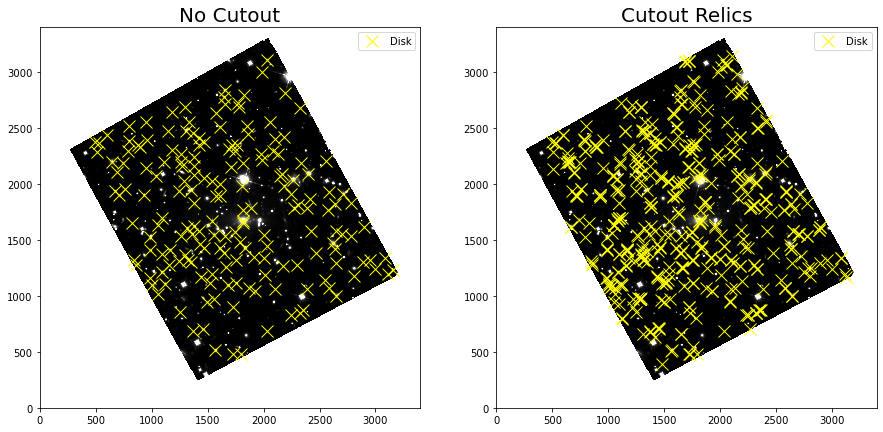

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs[0].plot(datmor_highdisk['x'], datmor_highdisk['y'], 'x', ms=12, color='yellow', label='Disk')
axs[0].set_title("No Cutout", fontsize=20)
axs[0].legend()

axs[1].imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs[1].plot(df_highdisk['real_x']-800, df_highdisk['real_y']-800, 'x', ms=12, color='yellow', label='Disk')
axs[1].set_title("Cutout Relics", fontsize=20)
axs[1].legend()

at df_highdisk subtracted 800 at center position this is becasue of size of image changed

original image size was (5000, 5000) and cut one is (3400, 3400) so center of img is (2500, 2500) vs (1700, 1700) that  is why subtracted 800

In [20]:
df_highdisk

id  location                                         morphology  \
0   1   [6, 52]  [-0.16658452861764492, 1.6390490090221994, -0....   
0   1  [28, 29]  [0.19859031844531042, 0.5907549481022134, 0.17...   
0   1  [13, 12]  [0.000952903224736972, 0.8452858944375563, 0.1...   
0   1  [54, 39]  [0.0, 0.9514512061504248, 0.04139985551570251,...   
0   1   [54, 8]  [0.0009607462265650425, 0.5199414158635334, 0....   
.. ..       ...                                                ...   
2   3  [48, 12]  [0.011815684641576198, 0.8755510275177547, 0.0...   
0   1  [28, 28]                               [0.0, 1.0, 0.0, 0.0]   
0   1  [28, 28]  [0.0, 0.8562611181353942, 0.14373888186460587,...   
0   1  [32, 40]  [0.0, 0.8803395044959808, 0.11670710288486459,...   
2   3   [42, 6]  [0.0, 0.5259129537758519, 0.43228099172341405,...   

            ra        dec     x     y     p_sph    p_disk     p_irr      p_ps  \
0    110.80945 -73.430198  52.0   6.0 -0.166585  1.639049 -0.013022 -0.459442   
0   110.812773 -73.431463  29.0  28.0   0.19859  0.590755  0.176122  0.034532   
0   110.832009 -73.430847  12.0  13.0  0.000953  0.845286  0.153438  0.000323   
0   110.834481 -73.430841  39.0  54.0       0.0  0.951451    0.0414  0.007149   
0   110.834064    -73.431   8.0  54.0  0.000961  0.519941   0.35061  0.128488   
..         ...        ...   ...   ...       ...       ...       ...       ...   
2   110.849906 -73.471912  12.0  48.0  0.011816  0.875551  0.097366  0.015267   
0   110.827704 -73.474558  28.0  28.0       0.0       1.0       0.0       0.0   
0   110.831883 -73.474526  28.0  28.0       0.0  0.856261  0.143739       0.0   
0   110.831869 -73.474525  40.0  32.0       0.0   0.88034  0.116707  0.002953   
2   110.846456 -73.475957   6.0  42.0       0.0  0.525913  0.432281  0.041806   

      real_x    real_y  
0   2910.354  3939.185  
0   2853.471  3863.344  
0   2524.337  3900.327  
0   2482.044  3900.672  
0   2489.189  3891.161  
..       ...       ...  
2   2218.798  1436.407  
0   2597.753   1277.67  
0   2526.427  1279.607  
0   2526.665  1279.638  
2   2277.738  1193.717  

[461 rows x 13 columns]

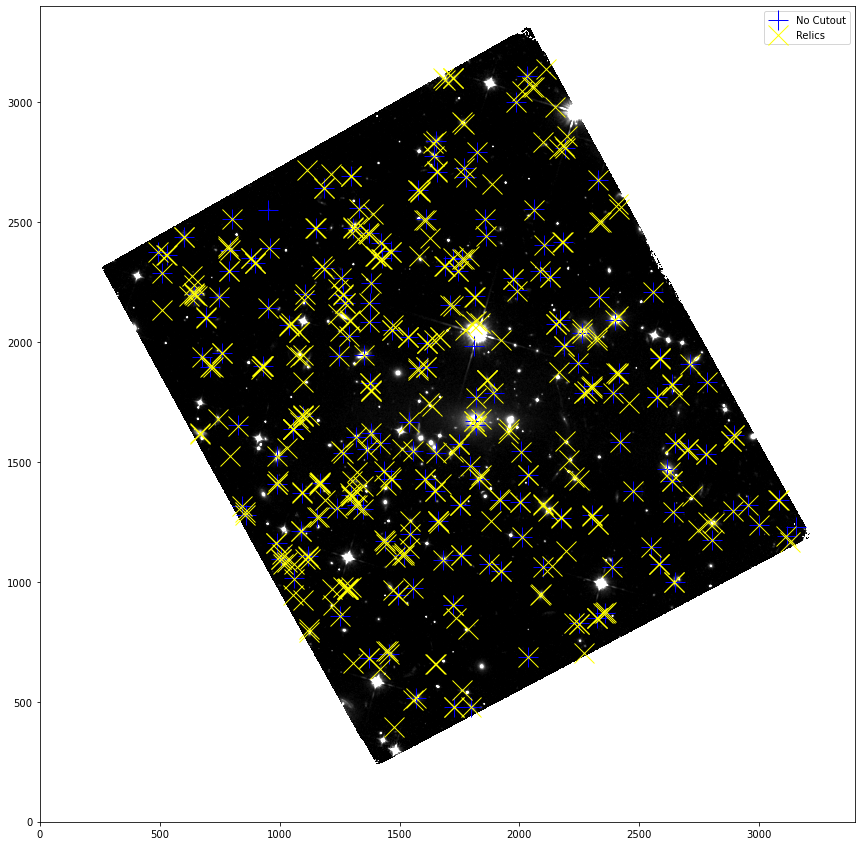

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.imshow(hcut, origin='lower', cmap='gray',  vmin=0, vmax=0.25)
axs.plot(datmor_highdisk['x'], datmor_highdisk['y'], '+', ms=20, color='blue', label='No Cutout')
axs.plot(df_highdisk['real_x']-800, df_highdisk['real_y']-800, 'x', ms=20, color='yellow', label='Relics')
axs.legend()